# RETO 1: Análisis de texto en Python - Bag of words (Bolsa de palabras)

### GRUPO 9 

1. Jonathan Álvarez
2. Juan Arias
3. María Fernanda Pacheco
4. Jairo Siza

# Iconos utilizados en este Notebook

🔔 Pregunta: Una pregunta rápida para ayudarte a entender lo que está pasando.

🥊 Desafío: Ejercicio interactivo. ¡Los trabajaremos en el taller!

🎬 Demo: Mostrar algo más avanzado - ¡para que sepas para qué se puede usar Python!

### SECCIONES 

1. Análisis exploratorio de datos
2. Preprocesamiento
3. Representación de la bolsa de palabras
4. Frecuencia de términos-Frecuencia inversa de documentos
5. Clasificación de sentimientos mediante la representación TF-IDF

En la parte anterior, aprendimos a realizar el preprocesamiento de texto. Sin embargo, no hemos ido más allá de los propios datos de texto. Si estamos interesados en realizar un análisis computacional de los datos de texto, necesitamos métodos para convertir el texto en una representación numérica.

En la Parte 2 de nuestra serie de talleres, exploraremos una de las formas más sencillas de generar una representación numérica a partir de texto: la bolsa de palabras (BoW). Implementaremos la representación BoW para transformar nuestros datos de tuits de aerolíneas y, a continuación, crearemos un clasificador para explorar lo que nos dice sobre el sentimiento de los tuits. En el núcleo del enfoque de la bolsa de palabras se encuentra la suposición de que la frecuencia de tokens específicos es informativa sobre la semántica y el sentimiento subyacentes en el texto.

Para ello, utilizaremos en gran medida el paquete scikit-learn, que proporciona un buen marco para construir la representación numérica.


Primero instalaremos **scikit-learn**, es el comando que nos permite instalar el paquete que permitirá realizar la bolsa de palabras

In [1]:
# Instalamos el paquete necesario
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


Aqui se instalaran los paquetes del lenguaje natural

In [2]:
%pip install NLTK
%pip install spaCy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.2 MB/s eta 0:00:00:00:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Importamos los demas paquetes para las demas funciones

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
%matplotlib inline

# Análisis de Datos Exploratorios 

Antes de realizar cualquier preprocesamiento o modelado, siempre debemos realizar un análisis exploratorio de datos para familiarizarnos con ellos.

In [4]:
tweets_path = '/kaggle/input/airline-tweets/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

In [5]:
tweets.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Como recordatorio, cada fila de este marco de datos corresponde a un tweet. Las siguientes columnas son de gran interés. Hay otras columnas que contienen metadatos del tweet, como: autor, fecha de creación, zona horaria del usuario, entre otros que dejaremos de lado por ahora.


* texto (str): el texto del tweet.
* airline_sentiment (str): el sentimiento del tweet, clasificado como "neutral", "positivo" o "negativo".
* airline (str): la aerolínea sobre la que se tuitea.
* retweet count (int): cuántas veces se retuiteó el tweet.

Para prepararnos para la clasificación de sentimientos, dividiremos el conjunto de datos para centrarnos en los tweets "positivos" y "negativos" por ahora.

In [6]:
tweets = tweets[tweets['airline_sentiment'] != 'neutral'].reset_index(drop=True)

¡Primero echemos un vistazo a algunos tweets!

In [7]:
#Imprime los 5 primeros tweets
for idx in range(5):
    print(tweets['text'].iloc[idx])

@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)


Ya podemos ver que algunos de estos tweets contienen sentimientos negativos. ¿Cómo podemos determinarlo?

A continuación, analicemos la distribución de las etiquetas de sentimiento en este conjunto de datos.

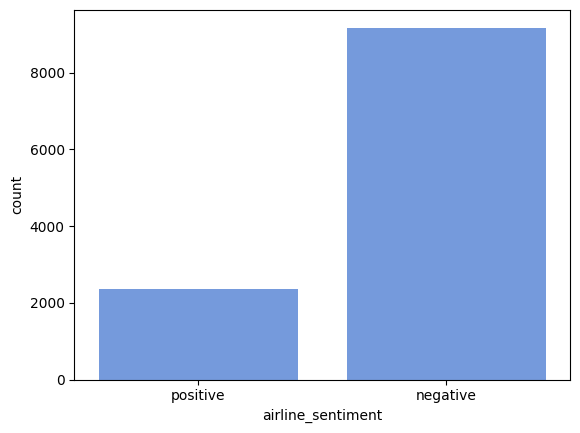

In [8]:
# Crea un gráfico de barras que muestra el recuento de sentimientos de los tweets
sns.countplot(data=tweets,
              x='airline_sentiment', 
              color='cornflowerblue',
              order=['positive', 'negative']);

Parece que la mayoría de los tweets de este conjunto de datos expresan un sentimiento negativo.

Veamos qué se retuitea con más frecuencia:

In [9]:
# Get the mean retweet count for each sentiment
tweets.groupby('airline_sentiment')['retweet_count'].mean()

airline_sentiment
negative    0.093375
positive    0.069403
Name: retweet_count, dtype: float64

¡Los tuits negativos se retuitean claramente con más frecuencia que los positivos!

Veamos qué aerolínea recibe más tweets negativos:

In [10]:
# Obtenga la proporción de tweets negativos por aerolínea
proportions = tweets.groupby(['airline', 'airline_sentiment']).size() / tweets.groupby('airline').size()
proportions.unstack().sort_values('negative', ascending=False)

airline_sentiment,negative,positive
airline,,
US Airways,0.893760,0.106240
American,0.853659,0.146341
United,0.842560,0.157440
Southwest,0.675399,0.324601
Delta,0.637091,0.362909
Virgin America,0.543544,0.456456


Parece que la aerolínea más insatisfecha es US Airways, seguida de American Airlines, ¡Ambas con más del 85 % de tweets negativos!

Se podrían hacer muchos descubrimientos interesantes si se desea explorar más sobre los datos. Ahora volvamos a nuestro análisis de sentimiento. Antes de eso, necesitamos preprocesar los datos de texto para que estén en un formato estándar.

# Preprocesamiento

En la Parte 1, nos dedicamos a aprender a preprocesar datos. ¡Apliquemos lo aprendido! Al observar algunos de los tweets anteriores, vemos que, si bien están en buen estado, podemos realizarles procesamiento adicional.

En nuestro pipeline, omitiremos el proceso de tokenización, ya que lo realizaremos en un paso posterior.

# 🥊 Desafío 1: Aplicar un pipeline de limpieza de texto

Escriba una función llamada **preproceso** que realice los siguientes pasos en una entrada de texto:


* Paso 1: Convierte el texto en minúsculas.
* Paso 2: Reemplaza los siguientes patrones con marcadores de posición:
  URLs → URL
  Digits → DIGIT
  Hashtags → HASHTAG
  Tweet handles → USER
* Paso 3: Elimina los espacios en blanco.

A continuación se ofrecen algunos consejos para guiarlo en este desafío:

* Para el Paso 1, recuerda de la Parte 1 que se puede usar un método de cadena llamado **.lower()** para convertir texto a minúsculas.
* Hemos integrado el Paso 2 en una función llamada **placeholder**. Ejecuta la celda a continuación para importarla a tu notebook y podrás usarla como cualquier otra función.
* Para el Paso 3, proporcionamos el patrón de expresiones regulares para identificar espacios en blanco, así como el reemplazo correcto para extraer espacios en blanco.

Ejecuta tu función **preprocess** en **example_tweet** (tres celdas más abajo) para comprobar si funciona. Si es así, aplícala a toda la columna **texto** del dataframe de tweets.

In [11]:
import re

url_pattern = r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
digit_pattern = '\d+'
hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
user_pattern = r'@(\w+)'

def placeholder(text):
    # Replace URLs
    url_pattern = r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
    url_repl = ' URL '
    text = re.sub(url_pattern, url_repl, text)
    # Replace digits
    digit_pattern = '\d+'
    digit_repl = ' DIGIT '
    text = re.sub(digit_pattern, digit_repl, text)
    # Replace hashtags
    hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
    hashtag_repl = ' HASHTAG '
    text = re.sub(hashtag_pattern, hashtag_repl, text)
    # Replace users
    user_pattern = r'@(\w+)'
    user_repl = ' USER '
    text = re.sub(user_pattern, user_repl, text)
    return text
    
blankspace_pattern = r'\s+'
blankspace_repl = ' '

def preprocess(text):
    '''Create a preprocess pipeline that cleans the tweet data.'''
    
    # Step 1: Minúsculas
    text = text.lower()

    # Step 2: Reemplaza las palabras
    text = placeholder(text) 

    # Step 3: Quitar los espacios extra
    text = re.sub(blankspace_pattern, blankspace_repl, text).strip()

    return text

In [12]:
example_tweet = 'lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo'

print(example_tweet)
print(f"{'='*50}")

# Mostrar texto reprocesado
print(preprocess(example_tweet))

lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo
lol USER and USER are like soo DIGIT HASHTAG HASHTAG saw it on URL HASHTAG


Ahora aplicamos la función a la columna de texto y asignamos los tweets preprocesados a una nueva columna

In [13]:
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0    USER plus you've added commercials to the expe...
1    USER it's really aggressive to blast obnoxious...
2        USER and it's a really big bad thing about it
3    USER seriously would pay $ DIGIT a flight for ...
4    USER yes, nearly every time i fly vx this “ear...
Name: text_processed, dtype: object

¡Felicitaciones! El preprocesamiento está listo. ¡Adentrémonos en el mundo the bag-of-words!

# Representación de la Bolsa de Palabras

La idea de la bolsa de palabras (BoW), como su nombre indica, es bastante intuitiva: tomamos un documento y lo metemos en una bolsa. La acción de "tirar" el documento en una bolsa ignora la posición relativa entre las palabras, por lo que lo que está "en la bolsa" es esencialmente "un conjunto no ordenado de palabras" (Jurafsky & Martin, 2024). A cambio, obtenemos una lista de palabras únicas y la frecuencia de cada una de ellas.

Por ejemplo, como se muestra en la siguiente ilustración, la palabra "café" aparece dos veces.

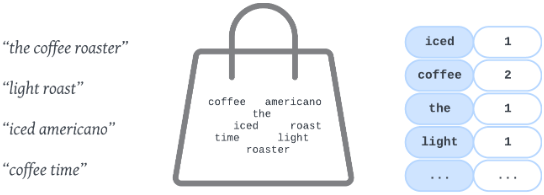

Con una representación de bolsa de palabras, hacemos un uso intensivo de la frecuencia de las palabras, pero no demasiado del orden de las mismas.

En el contexto del análisis de sentimiento, el sentimiento de un tweet se transmite con mayor fuerza mediante palabras específicas. Por ejemplo, si un tweet contiene la palabra "feliz", probablemente transmita un sentimiento positivo, pero no siempre, por ejemplo: "no feliz" denota el sentimiento opuesto. Cuanto más frecuentes sean estas palabras, probablemente transmitan el sentimiento con mayor fuerza.

# Matriz Documento-Término

Ahora implementemos la idea de la bolsa de palabras. Antes de profundizar, retrocedamos un momento. En la práctica, el análisis de texto suele implicar la gestión de muchos documentos; de ahora en adelante, usaremos el término **documento** para representar un fragmento de texto que analizamos. Podría ser una frase, una oración, un tweet o cualquier otro texto; siempre que pueda representarse mediante una cadena, la longitud no importa.

Imaginemos que tenemos cuatro documentos (es decir, las cuatro frases mostradas arriba) y los metemos todos en la bolsa. En lugar de una lista de frecuencia de palabras, esperaríamos obtener una matriz documento-término (DTM). En una DTM, la lista de palabras es el **vocabulario** (V) que contiene todas las palabras únicas que aparecen en los documentos. Para cada **documento** (D), contamos el número de ocurrencias de cada palabra en el vocabulario y luego introducimos el número en la matriz. En otras palabras, la DTM que construiremos es una matriz, donde cada fila corresponde a un documento y cada columna a un token (o "término").

Los tokens únicos de este conjunto de documentos, ordenados alfabéticamente, forman las columnas. Para cada documento, marcamos la ocurrencia de cada palabra presente en él. La representación numérica de cada documento es una fila en la matriz. Por ejemplo, el primer documento, "el tostador de café" ("the coffee roaster"), tiene la representación numérica **[0,1,0,0,0,1,1,0]**.

Tenga en cuenta que la columna de índice izquierda ahora muestra estos documentos como texto, pero normalmente solo asignaríamos un índice a cada uno de ellos.

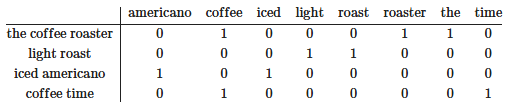

Para crear un DTM, utilizaremos **CountVectorizer** del paquete **sklearn**.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

La siguiente ilustración muestra el flujo de trabajo de tres pasos para crear un DTM con **CountVectorizr.**

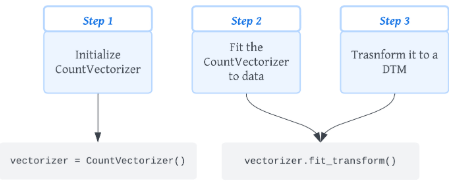

Repasemos estos pasos con el siguiente ejemplo de juguete.

# Un ejemplo de juguete
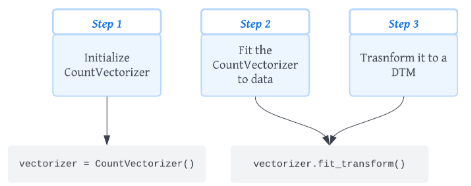

In [15]:
# El ejemplo de juguete contiene cuatro documentos.
test = ['the coffee roaster',
        'light roast',
        'iced americano',
        'coffee time']

El primer paso es inicializar un objeto **CountVectorizer**. Podemos especificar la configuración de los parámetros si lo deseamos.

Por ahora, podemos dejarlo en blanco para usar la configuración predeterminada.

In [16]:
# Creamos un vector para el conteo de palabras
vectorizer = CountVectorizer()

El segundo paso es ajustar (**fit**) este objeto **CountVectorizer** a los datos, lo que implica crear un vocabulario de tokens a partir del conjunto de documentos. El tercer paso es transformar (**transform**) nuestros datos según el objeto **CountVectorizer** "ajustado", lo que implica tomar cada documento y contar las ocurrencias de tokens según el vocabulario establecido durante el paso de"ajuste".

Puede parecer un poco complejo, pero los pasos 2 y 3 se pueden realizar de una sola vez mediante la función **fit_transform.** 

In [17]:
# Ajustamos y transformamos la data de test
test_count = vectorizer.fit_transform(test)

Se supone que el retorno de **fit_transform** es el DTM. ¡Echémosle un vistazo!

In [18]:
test_count

<4x8 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

Aparentemente, tenemos una "matriz dispersa", es decir, una matriz con muchos ceros. Esto tiene sentido. En cada documento, hay palabras que no aparecen, y estas se contabilizan como cero en el DTM. Esta matriz dispersa se almacena en formato de "fila dispersa comprimida", un formato que ahorra memoria y está diseñado para manejar matrices dispersas.

Convirtámoslo en una matriz densa, donde probablemente esos ceros estén representados, como en una matriz numpy.

In [20]:
#Conversion DTM a Matriz densa
test_count.todense()

matrix([[0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]])

¡Así que este es nuestro DTM! La matriz es la misma que se muestra arriba. Para que sea más legible, la convertiremos en un dataframe. Los nombres de las columnas deben ser tokens en el vocabulario, a los que podemos acceder con la función **get_feature_names_out**.

In [22]:
#Ahora convertimos la matriz en valores entendibles en lenguaje humano
vectorizer.get_feature_names_out()

array(['americano', 'coffee', 'iced', 'light', 'roast', 'roaster', 'the',
       'time'], dtype=object)

In [23]:
#Crear un DTM dataframe
test_dtm = pd.DataFrame(data=test_count.todense(),
                        columns=vectorizer.get_feature_names_out())

¡Aquí está! El DTM de nuestros datos de juguete ahora es un dataframe. El índice de **test_dtm** corresponde a la posición de cada documento en la lista **test**.

In [24]:
test_dtm

,americano,coffee,iced,light,roast,roaster,the,time
0,0,1,0,0,0,1,1,0
1,0,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1


Ahora sabiendo como funcionas las bolsas de palabras lo aplicaremos al dataset de tweets.

# DTM para Tweets

Comenzaremos inicializando un objeto **CountVectorizer**. En la siguiente celda, incluimos algunos parámetros que se ajustan con frecuencia. Estos parámetros están configurados con sus valores predeterminados.

Al construir un DTM, el texto de entrada se escribe en minúsculas por defecto. Si no se especifican **stop_words**, se conservan por defecto. Los siguientes tres parámetros controlan el tamaño del vocabulario, tema que abordaremos en breve.

In [25]:
# Crea un objeto CountVectorizer
vectorizer = CountVectorizer(lowercase=True,
                             stop_words=None,
                             min_df=1,
                             max_df=1.0, 
                             max_features=None)

Ahora formamos la matriz con el texto de tweets.

In [26]:
# Fit and transform to create DTM
counts = vectorizer.fit_transform(tweets['text_processed'])
counts

<11541x8751 sparse matrix of type '<class 'numpy.int64'>'
	with 191139 stored elements in Compressed Sparse Row format>

In [27]:
# Do not run if you have limited memory - this includes DataHub and Binder
np.array(counts.todense())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Definimos las columnas segun las diferentes palabras del dataset y formamos la matriz guiandonos en estos valores.

In [28]:
# Extract tokens
tokens = vectorizer.get_feature_names_out()

In [29]:
# Create DTM
first_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)
# Print the shape of DTM
print(first_dtm.shape)

(11541, 8751)


Si dejamos **CountVectorizer** con la configuración predeterminada, el tamaño del vocabulario de los datos del tweet es 8751.

In [30]:
first_dtm.head()

,_exact_,_wtvd,aa,aaaand,aadv,aadvantage,aal,aaron,ab,aback,...,zero,zig,zip,zippers,zone,zones,zoom,zukes,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La mayoría de los tokens no aparecen en al menos los primeros cinco tweets.

¡Echemos un vistazo más de cerca al DTM!

Ahora podemos mostrar las palabras mas repetidas en el dataset:

In [31]:
# Tokens más frecuentes
first_dtm.sum().sort_values(ascending=False).head(10)

user      12882
to         6987
digit      6927
the        5088
you        3635
for        3386
flight     3320
and        3276
on         3142
my         2751
dtype: int64

y los menos frecuentes:

In [33]:
# tokens menos frecuentes
first_dtm.sum().sort_values(ascending=True).head(10)

_exact_                     1
mightmismybrosgraduation    1
midterm                     1
midnite                     1
midland                     1
michelle                    1
michele                     1
michael                     1
mhtt                        1
mgmt                        1
dtype: int64

No sorprende que "usuario" y "dígito" se encuentren entre los tokens más frecuentes, ya que reemplazamos cada uno específico con estos marcadores. El resto de los tokens más frecuentes son principalmente palabras vacías.

Quizás un patrón más interesante sea buscar qué token aparece con más frecuencia en un tweet determinado:

In [34]:
counts = pd.DataFrame()

# Retrieve the index of the tweet where a token appears most frequently
counts['token'] = first_dtm.idxmax(axis=1)

# Retrieve the number of occurrence 
counts['number'] = first_dtm.max(axis=1)

# Filter out placeholders
counts[(counts['token']!='digit')
       & (counts['token']!='hashtag')
       & (counts['token']!='user')].sort_values('number', ascending=False).head(10)

,token,number
3127,lt,6
918,worst,6
10572,to,5
8148,the,5
10742,to,5
152,to,5
5005,to,5
10923,the,5
7750,to,5
355,to,5


Parece que, entre todos los tweets, un token aparece como máximo seis veces, y se trata de la palabra "It" o de la palabra "worst".

Regresemos a nuestro marco de datos de tweets y localicemos el tweet número 918.

In [35]:
# Retrieve 918th tweet: "worst"
tweets.iloc[918]['text']

"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!"

# Personalizar el CountVectorizer

Hasta ahora, siempre hemos usado la configuración predeterminada para crear nuestros DTM, pero en muchos casos, podemos querer personalizar el objeto **CountVectorizer**. El objetivo es filtrar aún más los tokens innecesarios. En el siguiente ejemplo, ajustamos los siguientes parámetros:


* stop_words = 'english': ignorar las stop words en inglés
* min_df = 2: ignorar las palabras que no aparecen al menos dos veces
* max_df = 0.95: ignorar palabras si aparecen en más del 95% de los documentos

🔔Pregunta: Detengámonos un momento para analizar si es razonable establecer estos parámetros. ¿Qué opinan?

A menudo, no nos interesan las palabras con frecuencias demasiado bajas o demasiado altas, por lo que usamos **min_df** y **max_df** para filtrarlas. Como alternativa, podemos definir el tamaño de nuestro vocabulario como **N** configurando el parámetro **max_features**. En otras palabras, le indicamos a **CountVectorizer** que solo considere los **N** tokens más frecuentes al construir el DTM.

In [36]:
# Personalizar la configuración de parámetros
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

# Ajustamos, transformamos y tomamos los valores para las columnas de la matriz
counts = vectorizer.fit_transform(tweets['text_processed'])
tokens = vectorizer.get_feature_names_out()

# Creamos una segunda matriz DTM
second_dtm = pd.DataFrame(data=counts.todense(),
                          index=tweets.index,
                          columns=tokens)

Nuestro segundo DTM tiene un vocabulario sustancialmente más pequeño en comparación con el primero.

In [37]:
print(first_dtm.shape)
print(second_dtm.shape)

(11541, 8751)
(11541, 4471)


In [38]:
second_dtm.head()

,aa,aadv,aadvantage,aal,abandoned,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La lista de tokens más frecuentes ahora incluye palabras que tienen más sentido para nosotros, como "cancelado" y "servicio".

In [39]:
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

# 🥊 Desafío 2: Lematizar la entrada de texto

Recuerde que en la Parte 1 presentamos el uso de **spaCy** para realizar lematización, es decir, para recuperar la forma base de una palabra. Este proceso reducirá el tamaño del vocabulario al minimizar las variaciones de palabras; un vocabulario más pequeño puede ayudar a mejorar el rendimiento del modelo en la clasificación de sentimientos.

Ahora implementemos la lematización en nuestros datos de tweets y usemos el texto lematizado para crear un tercer DTM.

Complete la función **lemmatize_text**. Requiere una entrada de texto y devuelve los lemas de todos los tokens.

Aquí tiene algunas sugerencias para guiarle en este desafío:


* Paso 1: Inicializar una lista para almacenar lemas
* Paso 2: Aplicar la secuencia de procesamiento de lenguaje natural (**NLP**) al texto de entrada
* Paso 3: Iterar sobre los tokens en el texto procesado y recuperar el lema del token
    PISTA: La lematización es una de las anotaciones lingüísticas que la secuencia de procesamiento de lenguaje natural (**NLP**) realiza automáticamente. Podemos usar **token.lemma_** para acceder a la anotación.

Lematización del texto ingresado:
"Lematización": Es llevar las palabras a su base, Ej:
running	run
better	good
studies	study
went	go

In [40]:
# Import spaCy
import spacy
# Carga del modelo de lenguaje en inglés
nlp = spacy.load('en_core_web_sm')

In [41]:
# Crear función para lematizar texto
def lemmatize_text(text):
    '''Lemmatize the text input with spaCy annotations.'''

    # Step 1: Initialize an empty list to hold lemmas
    lemmas = []

    # Step 2: Apply the nlp pipeline to input text
    doc = nlp(text)

    # Step 3: Iterate over tokens in the text to get the token lemma
    for token in doc:
        lemmas.append(token.lemma_)

    # Step 4: Join lemmas together into a single string
    text_lemma = ' '.join(lemmas)
    
    return text_lemma

¡Primero apliquemos la función al siguiente tweet de ejemplo!

In [42]:
# Apply the function to an example tweet
print(tweets.iloc[33]["text_processed"])
print(f"{'='*50}")
print(lemmatize_text(tweets.iloc[33]['text_processed']))

USER wow this just blew my mind
USER wow this just blow my mind


Luego lematizaremos los datos del tweet y guardaremos la salida en una nueva columna text_lemmatized.

In [44]:
# This may take a while!
tweets['text_lemmatized'] = tweets['text_processed'].apply(lambda x: lemmatize_text(x))

Ahora, con la columna **text_lemmatized**, crearemos un tercer DTM. La configuración de parámetros es la misma que la del segundo DTM.

In [45]:
# Create the vectorizer (the same param setting as previous)
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_lemmatized'])
tokens = vectorizer.get_feature_names_out()

# Create the third DTM
third_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)
third_dtm.head()

,aa,aadv,aadvantage,aal,abandon,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# Print the shapes of three DTMs
print(first_dtm.shape)
print(second_dtm.shape)
print(third_dtm.shape)

(11541, 8751)
(11541, 4471)
(11541, 3552)


Imprimamos los 10 tokens más frecuentes como de costumbre. Estos tokens ahora son lemas y sus conteos también cambian después de la lematización.

In [47]:
third_dtm.sum().sort_values(ascending=False).head(10)

digit       6927
flight      4043
hashtag     2633
thank       1455
hour        1134
cancel       948
delay        937
service      937
customer     902
time         856
dtype: int64

In [48]:
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

##   Frecuencia de Término - Frecuencia de Documento Inversa (TF-IDF)

Hasta ahora, nos basamos en la frecuencia de palabras para obtener información sobre un documento. Esto supone que si una palabra aparece con más frecuencia, es más informativa. Sin embargo, esto no siempre es así. Por ejemplo, ya hemos eliminado las palabras vacías porque no son informativas, a pesar de aparecer muchas veces en un documento. También sabemos que la palabra "vuelo" es una de las más frecuentes, pero no es tan informativa, ya que aparece en muchos documentos. Dado que estamos analizando tweets de aerolíneas, no debería sorprendernos ver la palabra "vuelo".

Para solucionar esto, utilizamos un esquema de ponderación llamado **tf-idf (frecuencia de término-frecuencia de documento inversa)**. La idea principal de **tf-idf** es ponderar una palabra no solo por su frecuencia dentro de un documento, sino también por su frecuencia en un documento en relación con los demás. Por lo tanto, al construir el DTM, asignaremos a cada término una **puntuación tf-idf** (tf-idf score). Específicamente, al término ***t*** en el documento ***d*** se le asigna una puntuación tf-idf de la siguiente manera:

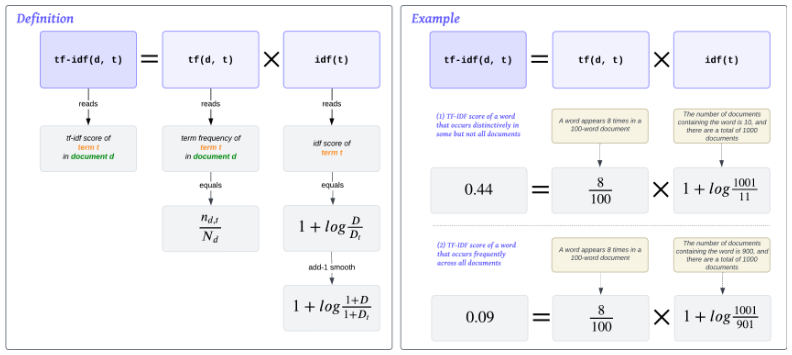

En esencia, la puntuación tf-idf de una palabra en un documento es el producto de dos componentes: la frecuencia del término (**tf**) y la frecuencia inversa del documento (**idf**). La idf actúa como un factor de escala. Si una palabra aparece en todos los documentos, la idf es igual a 1. No se produce escala. Sin embargo, la idf suele ser mayor que 1, que es el peso que asignamos a la palabra para aumentar la puntuación tf-idf y destacar su carácter informativo. En la práctica, sumamos 1 tanto al denominador como al numerador ("suavización de adición de 1") para evitar problemas con cero ocurrencias.

También podemos crear un DTM tf-idf con **sklearn**. En esta ocasión, usaremos un **TfidfVectorizer**:

In [49]:

from sklearn.feature_extraction.text import TfidfVectorizer
# Crear un vectorizador tfidf
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [50]:
# Ajustar y transformar 
tf_dtm = vectorizer.fit_transform(tweets['text_lemmatized'])
tf_dtm

<11541x3552 sparse matrix of type '<class 'numpy.float64'>'
	with 87822 stored elements in Compressed Sparse Row format>

In [51]:
# Create a tf-idf dataframe
tfidf = pd.DataFrame(tf_dtm.todense(),
                     columns=vectorizer.get_feature_names_out(),
                     index=tweets.index)
tfidf.head()

,aa,aadv,aadvantage,aal,abandon,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Se puede notar que el tamaño del vocabulario es el mismo que vimos en el Desafío 2. 
debido a que utilizamos la misma configuración de parámetros al crear el vectorizador. 
Pero los valores de la matriz son diferentes: son puntuaciones tf-idf en lugar de recuentos brutos.


##  Interpretar los valores TF-IDF

Veremos que un término tiene los valores tf-idf más altos. Usaremos el método .idxmax() para encontrar el índice.

In [52]:
tfidf.idxmax()

aa            10077
aadv           9285
aadvantage     9974
aal           10630
abandon        7859
              ...  
yyz            1350
zero           2705
zone           3177
zoom           3920
zurich        10622
Length: 3552, dtype: int64

Por ejemplo, el término «peor» aparece mas veces en el tuit 918.

In [53]:
tfidf.idxmax()['worst']

918

Ahora se muestra el tuit 918 y  la palabra «peor» aparece ¡seis veces!

In [54]:
tweets['text_processed'].iloc[918]

"USER is the worst. worst reservation policies. worst costumer service. worst worst worst. congrats, USER you're not that bad!"

Veamos otro ejemplo con la Palabra ¨Cancelar¨

In [55]:
tfidf.idxmax()['cancel']

5945

In [56]:
tweets['text_processed'].iloc[5945]

'USER cancelled flighted 😢'

## 🥊 Desafío 3: Palabras con las puntuaciones TF-IDF medias más altas

Hemos obtenido valores tf-idf para cada término en cada documento. Pero ¿qué nos dicen estos valores sobre el sentimiento de los tweets? ¿Hay palabras que sean especialmente informativas para los tweets positivos/negativos?

Para explorar esto, recopilemos los índices de todos los tweets positivos/negativos y calculemos la media de las puntuaciones tf-idf de las palabras que aparecen en cada categoría.

Hemos proporcionado el siguiente código de inicio como guía:

* Subconjunte el marco de datos de **tweets** según la etiqueta **airline_sentiment** y recupere el índice de cada subconjunto (**.index**). Asigne el índice a **positive_index** o **negative_index**.

Para cada subconjunto:

* Recuperar la representación td-idf.
* Tomar la media de los valores tf-idf del subconjunto utilizando .mean()
* Ordenar los valores medios en orden descendente mediante .sort_values()
* Obtenga los 10 términos principales con .head()

Ejecute **pos.plot** y **neg.plot** para representar las palabras con las puntuaciones tf-idf medias más altas de cada subconjunto.

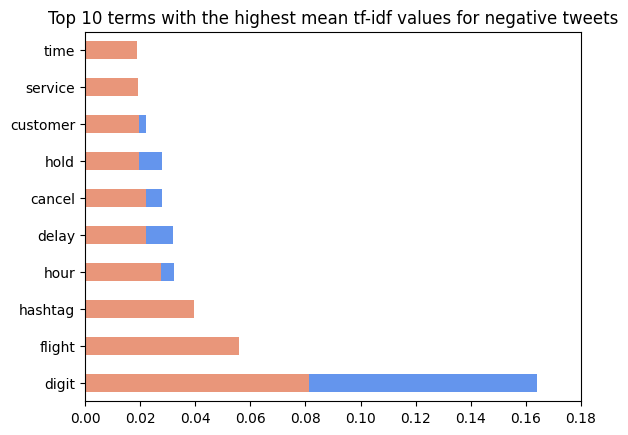

In [57]:
# Completa las máscaras booleanas
positive_index = tweets[tweets['airline_sentiment'] == 'positive'].index
negative_index = tweets[tweets['airline_sentiment'] == 'negative'].index

# Complete las siguientes dos líneas
pos = tfidf.loc[positive_index].mean().sort_values(ascending=False).head(10)
neg = tfidf.loc[negative_index].mean().sort_values(ascending=False).head(10)

pos.plot(kind='barh', 
         xlim=(0, 0.18),
         color='cornflowerblue',
         title='Top 10 terms with the highest mean tf-idf values for positive tweets');

neg.plot(kind='barh', 
         xlim=(0, 0.18),
         color='darksalmon',
         title='Top 10 terms with the highest mean tf-idf values for negative tweets');

## 🎬 Demo: Clasificación de sentimientos mediante la representación TF-IDF

Veremos brevemente cómo funciona la regresión logística como uno de los métodos supervisados de Aprendizaje Automático. La regresión logística es un modelo lineal, con el que predecimos la etiqueta de un tweet, basándonos en un conjunto de  características $x_1 , x_2, x_3  .... x_i $, como se muestra a continuación:
 $$ L=\beta_1x_1+\beta_2x_2+...+ \beta_T x_T$$
 
La lista de características que pasaremos al modelo es el vocabulario del MDT. También alimentamos el modelo con una parte de los datos, conocida como conjunto de entrenamiento, junto con otras especificaciones del modelo, para aprender el coeficiente ($\beta_1 , \beta_2, \beta_3  .... \beta_i $) de cada característica. 

-Los coeficientes nos indican si una característica contribuye positiva o negativamente al valor predicho. 

-El valor predicho corresponde a la suma de todas las características (multiplicadas por sus coeficientes).

-El valor predicho se pasa a una función sigmoidea para convertirlo en el espacio de probabilidad, que nos dice si la etiqueta predicha es positiva (cuando $p>0.5$) o negativa (cuando $p<0.5$).

La parte restante de los datos, conocida como conjunto de prueba, se utiliza para comprobar si los coeficientes aprendidos pueden generalizarse a datos no vistos.

In [58]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

Utilizaremos la función train_test_split de sklearn para separar nuestros datos en dos conjuntos:

In [59]:
# Train-test split
X = tfidf
y = tweets['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)


La función fit_logistic_regression se escribe a continuación para agilizar el proceso de entrenamiento.

In [60]:
def fit_logistic_regression(X, y):
    '''Fits a logistic regression model to provided data.'''
    model = LogisticRegressionCV(Cs=10,
                                 penalty='l1',
                                 cv=5,
                                 solver='liblinear',
                                 class_weight='balanced',
                                 random_state=42,
                                 refit=True).fit(X, y)
    return model

Ajustaremos el modelo y calcularemos la precisión de entrenamiento y de prueba.

In [61]:
# Ajustar el modelo de regresión logística
model = fit_logistic_regression(X_train, y_train)
# Obtener la precisión de entrenamiento y prueba
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 0.9432154144153329
Test accuracy: 0.8978060046189377


El modelo alcanzó una precisión del 94% en el conjunto de datos de entrenamiento y del 89% en el conjunto de datos de prueba.

Vemos los coeficientes ajustados para ver si lo que vemos tiene sentido.

Podemos acceder a ellos utilizando **coef_**, y podemos hacer coincidir cada coeficiente con los tokens del vectorizador:

In [62]:
# Obtener coefs de todas las características
coefs = model.coef_.ravel()

# Obtener todos los tokens
tokens = vectorizer.get_feature_names_out()

# Crear un marco de datos token-coef
importance = pd.DataFrame()
importance['token'] = tokens
importance['coefs'] = coefs
# Obtener los 10 tokens con los coeficientes más bajos
neg_coef = importance.sort_values('coefs').head(10)
neg_coef

,token,coefs
2723,rude,-10.087646
2783,screw,-9.630287
2726,ruin,-9.569026
1468,hold,-9.128239
1135,fail,-7.827361
2279,pay,-7.610135
1504,hour,-7.429489
1747,lack,-7.424794
1871,luggage,-7.251335
3033,strand,-7.162478


In [63]:
# Obtener los 10 tokens con coefs más altos
pos_coef = importance.sort_values('coefs').tail(10)
pos_coef 

,token,coefs
29,accrue,7.637920
1860,love,8.253252
3497,wonderful,8.504219
1091,exceptional,8.528895
115,amazing,8.564837
1372,great,8.827637
1089,excellent,9.228713
250,awesome,9.742946
1745,kudo,10.380300
3163,thank,16.807840


Grafiquemos los 10 tokens con los coeficientes más altos/bajos.


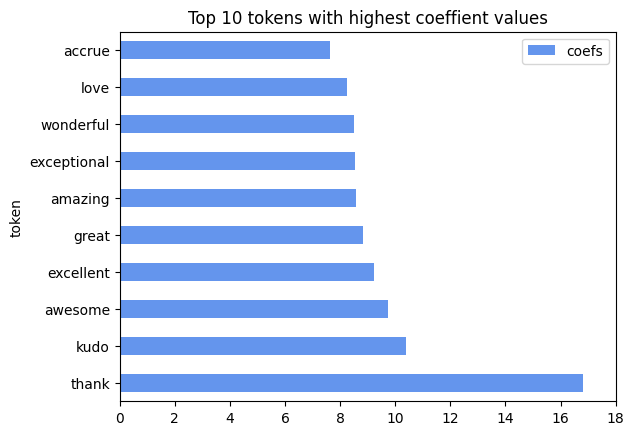

In [64]:
# Plot the top 10 tokens that have the highest coefs
pos_coef.sort_values('coefs', ascending=False) \
        .plot(kind='barh', 
              xlim=(0, 18),
              x='token',
              color='cornflowerblue',
              title='Top 10 tokens with highest coeffient values');

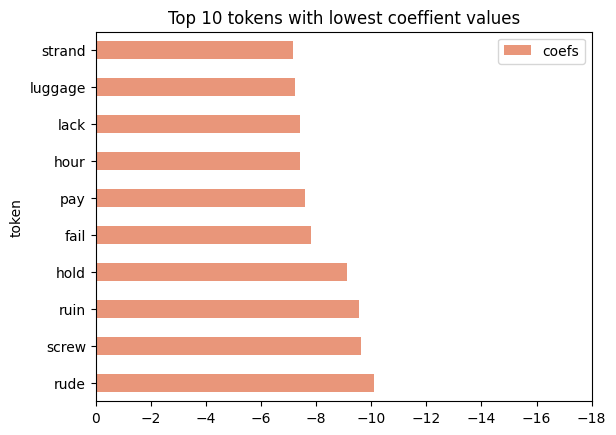

In [65]:
# Trazar los 10 tokens con los coeficientes más bajos
neg_coef.plot(kind='barh', 
              xlim=(0, -18),
              x='token',
              color='darksalmon',
              title='Top 10 tokens with lowest coeffient values');

Palabras como "ruin," "rude," and "hour" son fuertes indicadores de un sentimiento negativo, mientras que"thank," "awesome," and "wonderful"  se asocian a un sentimiento positivo.

Concluiremos la Parte 2 con estos gráficos. Estos términos de coeficiente y las palabras con los valores TF-IDF más altos ofrecen diferentes perspectivas sobre el sentimiento de los tweets. Si lo desea, tómese un tiempo para comparar los dos conjuntos de gráficos y ver cuál refleja mejor el sentimiento expresado en los tweets.

# ❗ Puntos clave

* Una representación de bolsa de palabras (Bag-of-Words) es un método sencillo para transformar nuestros datos de texto en números. Se centra en la frecuencia de las palabras, pero no en su orden.
* Una representación TF-IDF va un paso más allá; también considera si una palabra aparece de forma distintiva en un documento o si aparece de forma uniforme en todos.
* Con una representación numérica, podemos realizar diversas tareas de clasificación de texto, como el análisis de sentimientos.